In [96]:
from solver import classic_solver
from aspen import aspen_solver
import partion
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
def model(u):
    return np.array([u**2+1, 2*max(u, 0)])

class Diffusion():
    def __init__(self, Nx, Amp=0, Period=0, Scale=1, model=None):
        self.val = np.zeros((Nx+1, 1))
        for i in range(Nx+1):
            self.val[i] = (
                Amp * np.sin(Period * 2*np.pi * (i+1) / (Nx+1)) + 1) * Scale
        self.model = model

In [88]:
Nx = 1000
Nt = 100
param = {
    'Nx': Nx, 
    'Nt': Nt,
}
D = Diffusion(Nx, 0.9, 1, 0.5e-1, model=model)
solver_cl = classic_solver(param, D)
solver_cl.setBoundary(0, 0)
solver_cl.setInitial(0.5, 2, 1)
solver_cl.setSources([0.6], [0])

X_cl, code, message = solver_cl.solve()
print(X_cl)

[[1.00628302 0.18395257 0.04505367 ... 0.00355945 0.00353643 0.        ]
 [1.01256505 0.23234982 0.08305534 ... 0.00709884 0.00705293 0.        ]
 [1.01884509 0.27800452 0.12037093 ... 0.01061826 0.01054959 0.        ]
 ...
 [0.98743495 0.22110543 0.06388466 ... 0.00376111 0.00373784 0.        ]
 [0.99371698 0.1942747  0.04480876 ... 0.00250031 0.00248484 0.        ]
 [1.         0.16598435 0.02555196 ... 0.00124662 0.00123891 0.        ]]


In [97]:
Nx = 1000
Nt = 100
Nd = 6
param = {
    'Nx': Nx, 
    'Nt': Nt,
    'Nd': Nd
}
D = Diffusion(Nx, 0.9, 1, 0.5e-1, model=model)

part = partion.partion_equally
solver_as = aspen_solver(param, D, part)
solver_as.setBoundary(0, 0)
solver_as.setInitial(0.5, 2, 1)
solver_as.setSources([0.6], [0])

X, code, message = solver_as.solve()
print(X)

[[1.00628302 0.18378499 0.04484618 ... 0.00353231 0.00350961 0.        ]
 [1.01256505 0.23207261 0.08265601 ... 0.00704471 0.00699943 0.        ]
 [1.01884509 0.27762181 0.11978081 ... 0.0105373  0.01046958 0.        ]
 ...
 [0.98743495 0.22110543 0.06388466 ... 0.00375602 0.00373269 0.        ]
 [0.99371698 0.19427471 0.04480876 ... 0.00249692 0.00248141 0.        ]
 [1.         0.16598435 0.02555196 ... 0.00124494 0.0012372  0.        ]]


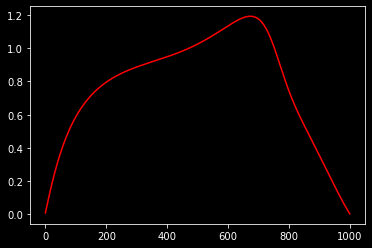

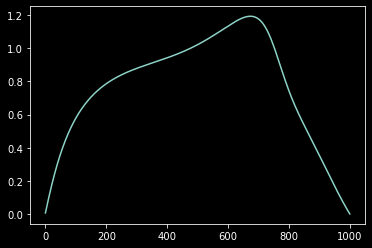

OK


In [89]:
step = 17
plt.style.use('dark_background')
plt.plot(X_cl[:, step], color = 'r')
plt.show()
plt.plot(X[:, step])
plt.show()
print(message)

In [98]:
print('aspen/newton comparsion')
print('---global versus newton---')
print('gb_resbld = {}, resbld ={}'.format(solver_as.timelog.gb_resbld, solver_cl.timelog.resbld))
print('gb_jacbld = {}, jacbld = {}'.format(solver_as.timelog.gb_jacbld, solver_cl.timelog.jacbld))
print('gb_linsol = {}, linsol = {}'.format(solver_as.timelog.gb_linsol, solver_cl.timelog.linsol))
print('---local+global time vs newton time---')
t1 = solver_as.timelog.gb_resbld+solver_as.timelog.gb_jacbld \
      +solver_as.timelog.gb_linsol+np.sum(solver_as.timelog.lc_resbld) \
      +np.sum(solver_as.timelog.lc_jacbld)+np.sum(solver_as.timelog.lc_linsol)
t2 = solver_cl.timelog.resbld+solver_cl.timelog.jacbld \
      +solver_cl.timelog.linsol
print('aspen = {}, newton = {}'.format(t1, t2))

aspen/newton comparsion
---global versus newton---
gb_resbld = 4.2514808177948, resbld =4.1663501262664795
gb_jacbld = 4.603047132492065, jacbld = 4.453916072845459
gb_linsol = 2.2309439182281494, linsol = 1.8157825469970703
---local+global time vs newton time---
aspen = 20.16522765159607, newton = 10.436048746109009


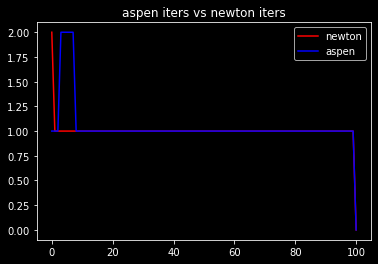

In [91]:
plt.title('aspen iters vs newton iters')
plt.plot(solver_cl.timelog.kn, color = 'r', label='newton')
plt.plot(solver_as.timelog.aspen_iters, color = 'b', label='aspen')
plt.legend()
plt.show()

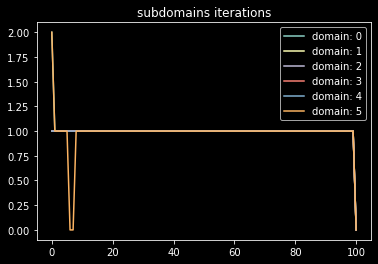

In [92]:
plt.title('subdomains iterations')

for i in range(Nd):
    plt.plot(solver_as.timelog.domain_iters[:, i], label='domain: {}'.format(i))
    
plt.legend()
plt.show()

In [84]:
print('subdomain time')
print('---resbld---')
print(solver_as.timelog.lc_resbld)
print('---jacbld---')
print(solver_as.timelog.lc_jacbld)
print('---linsol---')
print(solver_as.timelog.lc_linsol)

subdomain time
---resbld---
[0.84525752 0.82319736 0.86118412 0.83437586 0.84418035 0.88414884]
---jacbld---
[1.6484046  1.64583778 1.6237154  1.638767   1.65519023 1.72590518]
---linsol---
[0.04757714 0.04292631 0.04264522 0.04270148 0.04344726 0.04584742]


In [103]:
# okay, here comes the tricky part
# we will study the performance depending on domain sizes

t = []

for Nd in range(2, 17):
    Nx = 1000
    Nt = 100
    param = {
        'Nx': Nx, 
        'Nt': Nt,
        'Nd': Nd
    }
    D = Diffusion(Nx, 0.9, 1, 0.5e-1, model=model)

    part = partion.partion_equally
    solver = aspen_solver(param, D, part)
    solver.setBoundary(0, 0)
    solver.setInitial(0.5, 2, 1)
    solver.setSources([0.6], [0])

    X, code, message = solver.solve()
    tmp = solver.timelog.gb_resbld+solver.timelog.gb_jacbld \
          +solver.timelog.gb_linsol+np.sum(solver.timelog.lc_resbld) \
          +np.sum(solver.timelog.lc_jacbld)+np.sum(solver.timelog.lc_linsol)
    t.append(tmp)

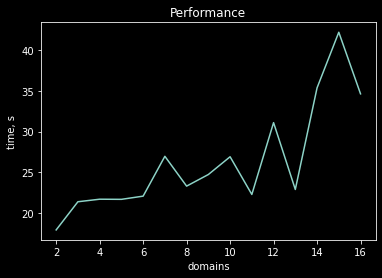

In [104]:
plt.title('Performance')
plt.xlabel('domains')
plt.ylabel('time, s')
plt.plot(np.arange(2, 17), t)

In [100]:
Nx = 1000
Nt = 100
Nd = 2
param = {
    'Nx': Nx, 
    'Nt': Nt,
    'Nd': Nd
}
D = Diffusion(Nx, 0.9, 1, 0.5e-1, model=model)

part = partion.partion_equally
solver_opt = aspen_solver(param, D, part)
solver_opt.setBoundary(0, 0)
solver_opt.setInitial(0.5, 2, 1)
solver_opt.setSources([0.6], [0])

X, code, message = solver_opt.solve()
print(X)

[[1.00628302 0.18395257 0.04505367 ... 0.00355903 0.00353601 0.        ]
 [1.01256505 0.23234982 0.08305534 ... 0.00709801 0.00705208 0.        ]
 [1.01884509 0.27800452 0.12037093 ... 0.01061701 0.01054833 0.        ]
 ...
 [0.98743495 0.22110543 0.06388466 ... 0.00376108 0.00373781 0.        ]
 [0.99371698 0.1942747  0.04480876 ... 0.00250029 0.00248482 0.        ]
 [1.         0.16598435 0.02555196 ... 0.00124661 0.0012389  0.        ]]


In [101]:
print('aspen/newton comparsion')
print('---global versus newton---')
print('gb_resbld = {}, resbld ={}'.format(solver_opt.timelog.gb_resbld, solver_cl.timelog.resbld))
print('gb_jacbld = {}, jacbld = {}'.format(solver_opt.timelog.gb_jacbld, solver_cl.timelog.jacbld))
print('gb_linsol = {}, linsol = {}'.format(solver_opt.timelog.gb_linsol, solver_cl.timelog.linsol))
print('---local+global time vs newton time---')
t1 = solver_opt.timelog.gb_resbld+solver_opt.timelog.gb_jacbld \
      +solver_opt.timelog.gb_linsol+np.sum(solver_opt.timelog.lc_resbld) \
      +np.sum(solver_opt.timelog.lc_jacbld)+np.sum(solver_opt.timelog.lc_linsol)
t2 = solver_cl.timelog.resbld+solver_cl.timelog.jacbld \
      +solver_cl.timelog.linsol
print('aspen = {}, newton = {}'.format(t1, t2))

aspen/newton comparsion
---global versus newton---
gb_resbld = 3.98179030418396, resbld =4.1663501262664795
gb_jacbld = 4.235978126525879, jacbld = 4.453916072845459
gb_linsol = 1.9336085319519043, linsol = 1.8157825469970703
---local+global time vs newton time---
aspen = 18.95385718345642, newton = 10.436048746109009


In [102]:
print('subdomain time')
print('---resbld---')
print(solver_opt.timelog.lc_resbld)
print('---jacbld---')
print(solver_opt.timelog.lc_jacbld)
print('---linsol---')
print(solver_opt.timelog.lc_linsol)

subdomain time
---resbld---
[2.08938289 2.08262539]
---jacbld---
[2.07690239 2.06050587]
---linsol---
[0.24664712 0.24641657]
